# Маркетинг

## 1. Общие данные

**Описание:**
Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продащи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

**Цель:**
Предсказать вероятность покупки в течении 90 дней

**Задачи:**
- Изучить данные;
- Разработать полезные признаки;
- Создать модель для классификации пользователей;
- Улучшить модель и максимизировать метрику roc-auc;
- Выполнить тестирование.

**Исходные данные:**
- Файл с историей покупок;

- Файл с историей рекламных рассылок;

- Файл с информацией: соверишит ли клиент покупку в течении следующих 90 дней;

- Файл с агрегицией общей базы рассылок по дням и типам событий;

- Файл с агрегацией по дням с учетом событий и каналов рассылки.

**План проекта:**

1) Загрузка исходных данных.

2) Изучение исходных данных. Обработка  некоректных типов данных, пропущенных значений, дубликатов, аномалий. 

3) Разработка полезных признаков. 

4) Подготовка данных для обучения моделей.

5) Обучение моделей для классификации пользователей ("Обучение с учителем") с основной метрикой roc-auc.

6) Улучшение модели и максимизация метрики roc-auc.

7) Тестирование лучшей модели.

## 2. Настройка и подготовка

Импортируем необходимые библиотеки

In [146]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import time

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler
)
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Настройки pandas
pd.set_option('display.float_format', '{:,.2f}'.format)

Зададим константы

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

Зададим функции

Функции для загрузки данных

In [3]:
# Функция для загрузки файлов CSV

def load_csv(filepath, parse_dates=None):
    """
    Вход: filepath - путь к файлу
          parse_dates - столбцы с датами
    Выход: датасет
    
    """
    if os.path.exists(filepath):
        try:
            df = pd.read_csv(filepath, parse_dates=parse_dates)
            print(f"{filepath} успешно загружен")
            return df
        except Exception as e:
            print(f"Ошибка при загрузке {filepath}: {e}")
            return None
    else:
        print(f"Файл {filepath} не найден")
        return None
    
# Функция для вывода первых строк 
# и размера датасета

def head_shape(df, num_str=5):
    """
    Вход: df - датасет
          num_str- количество выводимых строк
    Выход: первые n строк и размер датасета

    """
    display(df.head(num_str))
    print(df.shape)
    print('')
    return


Функции для анализа данных

In [4]:
# Функция для отображения пропусков
def miss_dupl(df):
    """
    Вход: df-датасет
    Выход: количество пропусков и дубликатов
    
    """
    print(f'Пропущенных значений:\n{df.isna().sum()}\n')
    
    print(f'Явных дубликатов:\n{df.duplicated().sum()}')
    
# Функция для просмотра уникальных значений
def uniq(df):
    """
    Ввод: df-датасет
    Вывод: уникальные значения столбца
    """
    for column in df.columns:
        print(f'{column}, {df[column].unique()}\n')
        
# Функция вывода общих данных 
def desc(df):
    """
    Ввод: df-датасет
    Вывод: общая информация о датасете
    """
    display(df.describe())
    if df.select_dtypes(include=[object]).shape[1] > 0:
        display(df.describe(include=[object]))

Функции для построения графиков

In [5]:
# Функция для построения гистограмм
def hist(df, col, bins, target=None, col_names=None):
    """
    Ввод: 
        df - датасет; 
        col - столбец; 
        bins - количество корзин; 
        target - целевая переменная;
        col_names - словарь с названиями столбцов 
    Вывод: гистограмма распределения признака с разбивкой по целевому признаку
    """
    sns.set()
    plt.figure(figsize=(10, 8))
    
    # Получаем читаемое название для оси X
    x_label = col_names.get(col, col) if col_names else col
    
    # Строим гистограмму
    if target is not None:
        # Получаем читаемое название для легенды
        hue_label = col_names.get(target, target) if col_names else target
        sns.histplot(df, bins=bins, hue=target, x=col)
        plt.legend(title=hue_label)
    else:
        sns.histplot(df, bins=bins, x=col)
    
    plt.title(f'Распределение признака {x_label}', fontsize=16)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel('Частота', fontsize=14)
    plt.show()

# Функция для построения гистограмм совместно с графиком ящик с усами
def hist_box(df, col, bins, target=None, col_names=None):
    """
    Ввод: 
        df - датасет; 
        col - столбец; 
        bins - количество корзин; 
        target - целевая переменная;
        col_names - словарь с названиями столбцов 
    Вывод: гистограмма распределения признака и график ящик с усами
    """
    sns.set()
    f, axes = plt.subplots(2, 1, figsize=(10, 8))  
    
    # Получаем читаемое название для оси X
    x_label = col_names.get(col, col) if col_names else col
    
    # Верхний график - гистограмма
    axes[0].set_title(f'Распределение признака {x_label}', fontsize=16)
    axes[0].set_ylabel('Частота', fontsize=14)
    axes[0].set_xlabel(x_label, fontsize=14)  # ДОБАВЛЕНО: подпись оси X для верхнего графика
    
    if target is not None:
        # Получаем читаемое название для легенды
        hue_label = col_names.get(target, target) if col_names else target
        sns.histplot(df, bins=bins, ax=axes[0], hue=target, x=col)
        axes[0].legend(title=hue_label)
    else:
        sns.histplot(df, bins=bins, ax=axes[0], x=col)
    
    # Нижний график - ящик с усами
    axes[1].set_title(f'Ящик с усами для признака {x_label}', fontsize=16)
    sns.boxplot(data=df, ax=axes[1], x=col)
    axes[1].set_xlabel(x_label, fontsize=14)
    axes[1].set_ylabel('Значения', fontsize=14)
    
    plt.tight_layout() 
    plt.show()

# Функция для построения столбчатой диаграммы
def countplot(df, col, target=None, col_names=None):
    """
    Ввод: 
        df - датасет; 
        col - столбец; 
        target - целевая переменная;
        col_names - словарь с названиями столбцов 
    Вывод: столбчатая диаграмма распределения с разбивкой по целевому признаку
    """
    plt.figure(figsize=(10, 8))
    
    # Получаем читаемые названия
    x_label = col_names.get(col, col) if col_names else col
    
    plot = sns.countplot(data=df, x=col, hue=target)
    plot.set_title(f'Распределение по {x_label}', fontsize=16)
    plot.set_ylabel('Количество', fontsize=14)
    plot.set_xlabel(x_label, fontsize=14)
    
    # Добавляем поворот подписей если они длинные
    if df[col].nunique() > 5:
        plt.xticks(rotation=45, ha='right')
    
    # Добавляем легенду если есть target
    if target is not None:
        hue_label = col_names.get(target, target) if col_names else target
        plt.legend(title=hue_label)
    
    plt.tight_layout()
    plt.show()

# Функция для построения диаграммы рассеяния
def scatter(df, col, target, col_names=None):
    """
    Ввод: 
        df - датасет; 
        col - столбец; 
        target - целевая переменная;
        col_names - словарь с человекочитаемыми названиями столбцов (опционально)
    Вывод: диаграмма рассеяния col от target
    """
    plt.figure(figsize=(10, 6))
    
    # Получаем читаемые названия для осей
    x_label = col_names.get(col, col) if col_names else col
    y_label = col_names.get(target, target) if col_names else target
    
    sns.scatterplot(
        data=df, 
        x=col, 
        y=target,
        alpha=0.7,  
        s=50        
    )
    plt.title(f'Диаграмма рассеяния: {x_label} vs {y_label}', fontsize=16)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()

Функция для построения корреляционного анализа

In [6]:
def phik_mat(df, interval_cols=None):
    """
    Ввод: df - датасет; 
    interval_cols - список с интервальными признаками;
    
    Вывод: матрица корреляции Phik
    """
    phik_matrix = df.phik_matrix(verbose=False, interval_cols=interval_cols)
    
    mask = np.triu(np.ones_like(phik_matrix, dtype=bool))
    
    plt.figure(figsize=(20, 15))
    sns.heatmap(
        phik_matrix, 
        annot=True, 
        fmt='.2f',
        cmap="coolwarm",
        mask=mask)
    plt.title('Корреляционная матрица (Phik)', fontsize=18)
    plt.show()

Функция для вывода результатов обучения модели на кросс-валидации

In [92]:
def print_best_metrics(cv_results):
    """
    Выводит метрики лучшей модели по ROC-AUC из результатов кросс-валидации.
    
    Parameters:
    -----------
    cv_results : pandas DataFrame
        Результаты кросс-валидации из GridSearchCV/RandomizedSearchCV
    """
    best_roc_idx = cv_results['mean_test_roc_auc'].idxmax()
    
    best_metrics = {
        'roc_auc': {
            'mean': cv_results.loc[best_roc_idx, 'mean_test_roc_auc'],
            'std': cv_results.loc[best_roc_idx, 'std_test_roc_auc']
        },
        'f1': {
            'mean': cv_results.loc[best_roc_idx, 'mean_test_f1'],
            'std': cv_results.loc[best_roc_idx, 'std_test_f1']
        },
        'precision': {
            'mean': cv_results.loc[best_roc_idx, 'mean_test_precision'],
            'std': cv_results.loc[best_roc_idx, 'std_test_precision']
        },
        'recall': {
            'mean': cv_results.loc[best_roc_idx, 'mean_test_recall'],
            'std': cv_results.loc[best_roc_idx, 'std_test_recall']
        }
    }
    
    print("=" * 50)
    print("МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ (по ROC-AUC)")
    print("=" * 50)
    for metric_name, values in best_metrics.items():
        print(f"{metric_name.upper():12} | Среднее: {values['mean']:.4f}")

## 3. Загрузка исходных данных

Создадим переменные для загрузки данных

In [7]:
# Переменные pth_ - пути до файла, 
# переменные column_date_ - столбцы с датами
pth_1 = 'initial_data/apparel-messages.csv'
column_date_1 = ['date', 'created_at']

pth_2 = 'initial_data/apparel-purchases.csv'
column_date_2 = ['date']

pth_3 = 'initial_data/apparel-target_binary.csv'

pth_4 = 'initial_data/full_campaign_daily_event.csv'
column_date_4 = ['date']

pth_5 = 'initial_data/full_campaign_daily_event_channel.csv'
column_date_5 = ['date']

In [8]:
# Загрузим исходные файлы в датафреймы
initial_messages = load_csv(pth_1, column_date_1 )
initial_purchases = load_csv(pth_2, column_date_2)
initial_target = load_csv(pth_3, None)
daily_event = load_csv(pth_4, column_date_4)
daily_chanel_event = load_csv(pth_5, column_date_5)

initial_data/apparel-messages.csv успешно загружен
initial_data/apparel-purchases.csv успешно загружен
initial_data/apparel-target_binary.csv успешно загружен
initial_data/full_campaign_daily_event.csv успешно загружен
initial_data/full_campaign_daily_event_channel.csv успешно загружен


Проверим датасеты

In [9]:
# Создадим словарь с именами и датасетами
data = {
    'initial_messages': initial_messages,
    'initial_purchases': initial_purchases,
    'initial_target': initial_target,
    'daily_event': daily_event,
    'daily_chanel_event': daily_chanel_event
}

In [10]:
# Выведем первые пять строк и размер датасета
# Используем цикл для перебора
for name, df in data.items():
    print(f"Датасет: {name}")
    head_shape(df)

Датасет: initial_messages


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


(12739798, 7)

Датасет: initial_purchases


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,"1,999.00","['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,"2,499.00","['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,"6,499.00","['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,"4,999.00","['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,"4,999.00","['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


(202208, 6)

Датасет: initial_target


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


(49849, 2)

Датасет: daily_event


,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


(131072, 24)

Датасет: daily_chanel_event


,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(131072, 36)



Все данные отображаются корректно

Проверим общую информацию о датасетах

In [11]:
for name, df in data.items():
    print('')
    print(f"Датасет: {name}")
    df.info()


Датасет: initial_messages
<class 'pandas.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        str           
 3   event             str           
 4   channel           str           
 5   date              datetime64[us]
 6   created_at        datetime64[us]
dtypes: datetime64[us](2), int64(2), str(3)
memory usage: 680.4 MB

Датасет: initial_purchases
<class 'pandas.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  str           
 4   date          202208 no

### 3.1 Промежуточный вывод

Данные заружены, установлена настройка при чтении файла, для обработки столбцов с датами. Наименования столбцов имеют "змеиный" регистр. Все данные имеют корректный тип данных.

## 4. Изучение исходных данных


### 4.1 Общая статистика

Выведем общую статистику по столбцам

#### 4.1.1 Данные о рассылках

In [12]:
desc(initial_messages)

,bulk_campaign_id,client_id,date,created_at
count,"12,739,798.00","12,739,798.00",12739798,12739798
mean,"11,604.59","1,515,915,625,574,831,616.00",2023-06-05 02:46:08.357992,2023-06-05 13:58:11.168685
min,548.00,"1,515,915,625,468,060,928.00",2022-05-19 00:00:00,2022-05-19 00:14:20
25%,"8,746.00","1,515,915,625,489,149,440.00",2022-12-19 00:00:00,2022-12-19 12:46:30
50%,"13,516.00","1,515,915,625,503,432,192.00",2023-07-20 00:00:00,2023-07-20 17:21:54
75%,"14,158.00","1,515,915,625,591,286,272.00",2023-11-21 00:00:00,2023-11-21 18:13:05
max,"14,657.00","1,515,915,626,010,288,640.00",2024-02-15 00:00:00,2024-02-15 23:58:40
std,"3,259.21","132,970,411.56",NaN,NaN


C:\Users\Арслан\AppData\Local\Temp\ipykernel_6076\1285393437.py:28: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  if df.select_dtypes(include=[object]).shape[1] > 0:
C:\Users\Арслан\AppData\Local\Temp\ipykernel_6076\1285393437.py:29: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/m

,message_id,event,channel
count,12739798,12739798,12739798
unique,9061667,11,2
top,1515915625489095763-6251-6311b13a4cf78,send,mobile_push
freq,1454,9058196,7512156


По общей статистике рассылок видно, что столбец `date` и `created_at` один и тот же столбец, только один с точным временем, а другой без. А также видно, что у нас два уникальных канала коммуникации, самый популярный из них пуш-уведомления на телефоне. Есть 11 уникальных действий, самым популярным является `send`. Датасет содержит данные за период с 19.12.2022 по 15.02.2024 год.

#### 4.1.2 Данные о покупках

In [13]:
desc(initial_purchases)

,client_id,quantity,price,date
count,"202,208.00","202,208.00","202,208.00",202208
mean,"1,515,915,625,596,210,944.00",1.01,"1,193.30",2023-03-17 02:49:35.739831
min,"1,515,915,625,468,060,928.00",1.00,1.00,2022-05-16 00:00:00
25%,"1,515,915,625,490,081,280.00",1.00,352.00,2022-11-12 00:00:00
50%,"1,515,915,625,557,177,088.00",1.00,987.00,2023-04-12 00:00:00
75%,"1,515,915,625,624,391,936.00",1.00,"1,699.00",2023-07-03 00:00:00
max,"1,515,915,626,010,443,520.00",30.00,"85,499.00",2024-02-16 00:00:00
std,"145,945,755.93",0.18,"1,342.25",NaN


C:\Users\Арслан\AppData\Local\Temp\ipykernel_6076\1285393437.py:28: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  if df.select_dtypes(include=[object]).shape[1] > 0:
C:\Users\Арслан\AppData\Local\Temp\ipykernel_6076\1285393437.py:29: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/m

,category_ids,message_id
count,202208,202208
unique,933,50204
top,"['4', '28', '57', '431']",1515915625489095763-6251-6311b13a4cf78
freq,8626,365


По статистике данных о покупке видно, что в среднем покупатель покупает 1 единицу товара, максимальное значение 30 единиц товара в одном чеке. У нас есть данный за период с 16.05.2022 по 16.02.2024. Самая маленька сумма покупки равна 1, а сумма самого большого чека 85499.

#### 4.1.3 Данные с информацией, совершил ли покупку клиент в течении 90 дней

In [14]:
desc(initial_target)

,client_id,target
count,"49,849.00","49,849.00"
mean,"1,515,915,625,598,796,032.00",0.02
std,"148,794,654.89",0.14
min,"1,515,915,625,468,060,928.00",0.00
25%,"1,515,915,625,489,972,736.00",0.00
50%,"1,515,915,625,556,614,912.00",0.00
75%,"1,515,915,625,633,408,768.00",0.00
max,"1,515,915,626,010,443,520.00",1.00


Видно, что только 2 процента совершили покупку в срок 90 дней.

#### 4.1.4 Агрегированные данные рассылок по дням и типам события, также агрегированные данные рассолок по дням с учетом событий и каналов рассылки

In [15]:
# Зададим инструкцию для вывода всех столбцов
with pd.option_context('display.max_columns', None):
    desc(daily_event)

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,nunique_click,nunique_complain,nunique_hard_bounce,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
count,131072,"131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00"
mean,2023-05-11 18:39:38.320312,"8,416.74",90.98,0.93,78.47,"3,771.09",0.58,"11,634.14",27.81,0.14,6.36,74.28,0.92,77.40,"3,683.00",0.47,"11,537.16",27.57,0.13,5.96,0.81,0.81,0.00,0.00
min,2022-05-19 00:00:00,548.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2022-11-06 00:00:00,"4,116.00",0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,2023-04-01 00:00:00,"7,477.00",0.00,0.00,0.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2023-12-25 00:00:00,"13,732.00",2.00,0.00,0.00,30.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,30.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
max,2024-05-15 00:00:00,"15,150.00","128,453.00","5,160.00","287,404.00","5,076,151.00","1,077.00","11,543,513.00","76,284.00",189.00,"9,089.00","75,899.00","5,043.00","287,341.00","2,922,440.00",779.00,"7,094,600.00","76,281.00",177.00,"8,299.00","63,920.00","63,920.00",1.00,1.00
std,NaN,"4,877.37","1,275.50",30.20,"1,961.32","65,160.67",9.11,"175,709.51",736.94,2.07,79.17,"1,004.27",29.72,"1,913.40","62,586.47",7.13,"172,700.49",734.05,1.98,73.28,183.30,183.30,0.00,0.00


In [16]:
# Зададим инструкцию для вывода всех столбцов
with pd.option_context('display.max_columns', None):
    desc(daily_chanel_event)

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,nunique_click_email,nunique_click_mobile_push,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_soft_bounce_email,nunique_subscribe_email,nunique_unsubscribe_email,count_hard_bounce_mobile_push,count_send_mobile_push,nunique_hard_bounce_mobile_push,nunique_send_mobile_push,count_hard_bounce_email,count_hbq_spam_email,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
count,131072,"131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00"
mean,2023-05-11 18:39:38.320312,"8,416.74",41.58,49.40,423.71,"3,347.38",0.36,0.22,24.47,0.14,6.36,31.40,42.88,411.66,"3,271.34",0.29,0.18,24.26,0.13,5.96,59.48,"7,444.56",58.86,"7,350.27",18.99,0.81,"4,189.58",18.54,0.81,"4,186.90",3.33,3.31,0.93,0.92,0.00,0.00
min,2022-05-19 00:00:00,548.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2022-11-06 00:00:00,"4,116.00",0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,2023-04-01 00:00:00,"7,477.00",0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2023-12-25 00:00:00,"13,732.00",1.00,0.00,23.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,23.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,2024-05-15 00:00:00,"15,150.00","59,365.00","128,453.00","2,597,015.00","5,076,151.00","1,077.00",431.00,"76,284.00",189.00,"9,089.00","45,718.00","75,899.00","2,548,617.00","2,922,440.00",779.00,359.00,"76,281.00",177.00,"8,299.00","165,526.00","11,543,513.00","165,526.00","6,636,578.00","287,404.00","63,920.00","7,094,600.00","287,341.00","63,920.00","7,094,600.00","21,831.00","21,389.00","5,160.00","5,043.00",1.00,1.00
std,NaN,"4,877.37",745.48,"1,036.95","9,753.38","64,448.59",8.29,3.80,727.07,2.07,79.17,562.88,833.32,"9,519.71","61,880.01",6.48,2.97,724.27,1.98,73.28,"1,371.96","139,350.92","1,357.27","135,579.92","1,402.41",183.30,"107,319.76","1,349.47",183.30,"107,261.80",120.92,120.09,30.20,29.72,0.00,0.00


В данных файлах собраны агрегированные данные, `count_event*` содержит общее количество каждого события, `nunique_event*` содержит количество уникальных пользователей в каждом событии, `count_event*_channel*` содержит общее количество каждого события по каналам, `nunique_event*_channel*` содержит количество уникальных пользователей по событиям и каналам. 

### 4.2 Неявные дубликаты 

In [17]:
initial_messages['event'].value_counts()

event
send           9058196
open           3085820
click           496339
purchase         64679
hard_bounce      19903
soft_bounce      10583
unsubscribe       2841
hbq_spam           823
complain           528
subscribe           85
close                1
Name: count, dtype: int64

In [18]:
initial_messages['channel'].value_counts()

channel
mobile_push    7512156
email          5227642
Name: count, dtype: int64

Неявных дубликатов не обнаружено

### 4.3 Аномальные значения

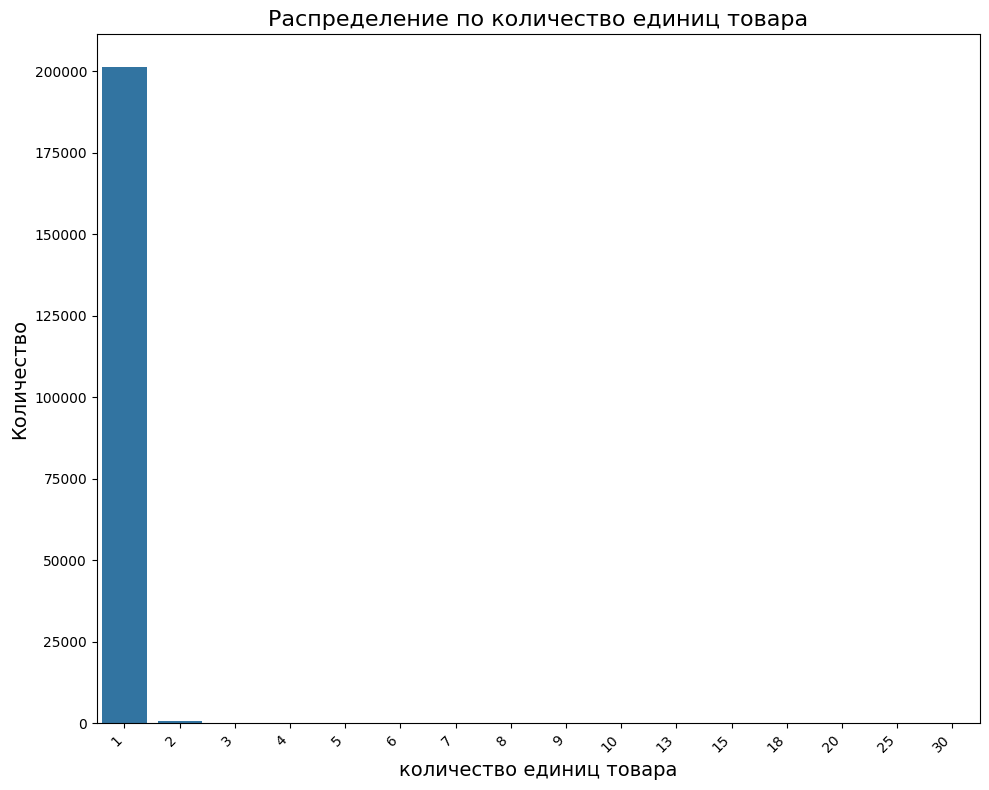

In [19]:
col_name = {'quantity': 'количество единиц товара',
            'price': 'цена товара'}

countplot(initial_purchases, 'quantity', None, col_name)

В основном в чеке только 1 единица товара. Проверим строки в которых в чеке более 1 единицы товара

In [20]:
initial_purchases.loc[
    initial_purchases['quantity'] > 1,
      'quantity'
      ].value_counts()

quantity
2     751
3      94
4      12
6       5
10      4
20      3
15      3
5       3
25      2
30      2
9       2
13      1
18      1
8       1
7       1
Name: count, dtype: int64

Видно, что в чеках встречаются разное количество товаров, аномальные значения отсутствуют.

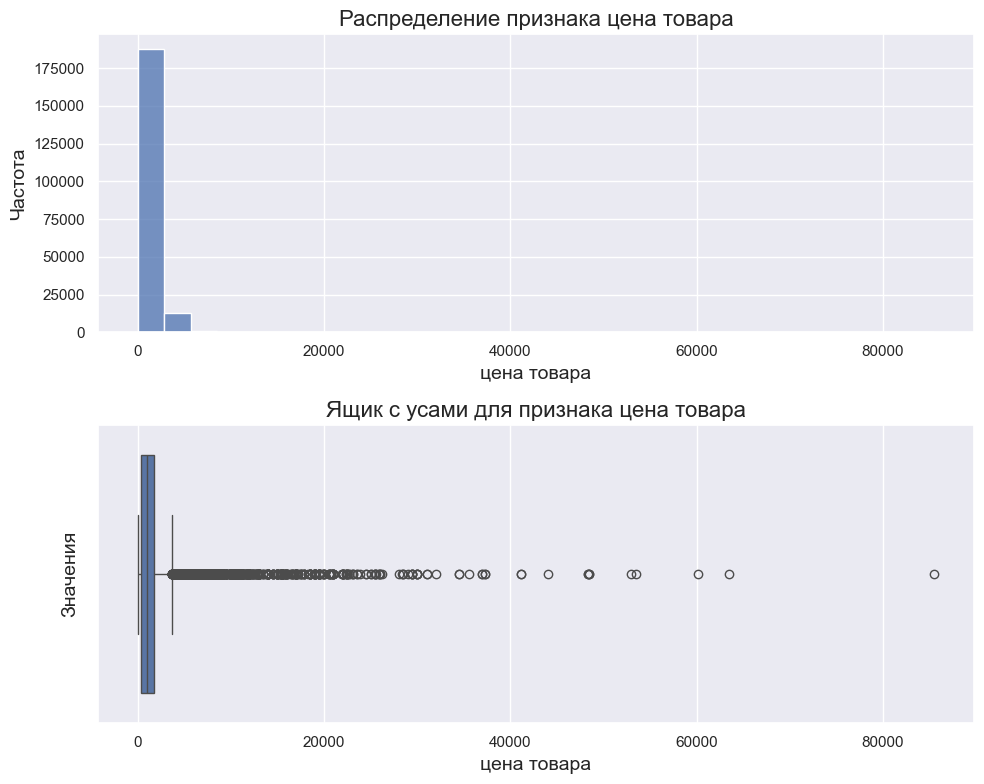

In [21]:
hist_box(initial_purchases, 'price', 30, None, col_name)

Видно, что основное количество товаров стоит до 10 тысяч. Проверим сроки с большим значением цены товара

In [22]:
# Отсортируем строки с ценой выше 30'000
initial_purchases.loc[initial_purchases['price'] > 30000]

,client_id,quantity,price,category_ids,date,message_id
6018,1515915625692218402,1,"48,499.00","['4', '29', '312', '1576']",2022-06-01,1515915625489907961-4679-62972222453b3
70064,1515915625490563372,1,"31,999.00","['4', '29', '312', '1576']",2022-12-20,1515915625490563372-8813-63a1acf4d6e83
138818,1515915625971673322,1,"53,499.00","['4', '29', '310', '1577']",2023-06-13,1515915625971673322-13342-648873c693815
151607,1515915625487894579,1,"31,080.00","['4', '29', '310', '1577']",2023-07-03,1515915625487894579-13427-649e839ea11d7
151608,1515915625487894579,1,"31,080.00","['4', '29', '310', '1577']",2023-07-03,1515915625487894579-13427-649e839ea11d7
166576,1515915625776653984,1,"63,499.00","['4', '29', '310', '1577']",2023-08-26,1515915625776653984-13719-64e85f9332bc8
166577,1515915625776653984,1,"35,559.00","['4', '29', '310', '1577']",2023-08-26,1515915625776653984-13719-64e85f9332bc8
166578,1515915625776653984,1,"60,200.00","['4', '29', '310', '1577']",2023-08-26,1515915625776653984-13719-64e85f9332bc8
171434,1515915625959777467,1,"43,999.00","['4', '29', '313', '1574']",2023-09-27,1515915625959777467-13868-6513cbb257da6
171435,1515915625959777467,1,"48,499.00","['4', '29', '313', '1574']",2023-09-27,1515915625959777467-13868-6513cbb257da6


Видно, что в данных строках количество товаров равно 1. Также видно чеки с одинаковыми категориями, но с разной ценой, это может быть связано со скидкой или повышении цен в зависимости от даты. Посмотрим количество строк с ценой выше 10000.

In [23]:
# Отсортируем строки с ценой выше 10'000
more_ten = initial_purchases.loc[
    initial_purchases['price'] > 10000,
      'price'
      ].count()
# Найдем долю строк с ценой выше 10'000 к общему количеству
(more_ten / initial_purchases.shape[0]) * 100

np.float64(0.1641873714195284)

Доля строк с ценой выше 10000 составляет 0,16 % от общего количества строк. Удалим данные строки, для исключения смещения распределения в сторону большей цены.

In [24]:
# Создадим копию исходного датасета
purchases = initial_purchases.copy()

# Удалим строки с ценой более 10'000
purchases = purchases[purchases['price'] < 10000]

Проверим распределение по цене в обновленном датасете

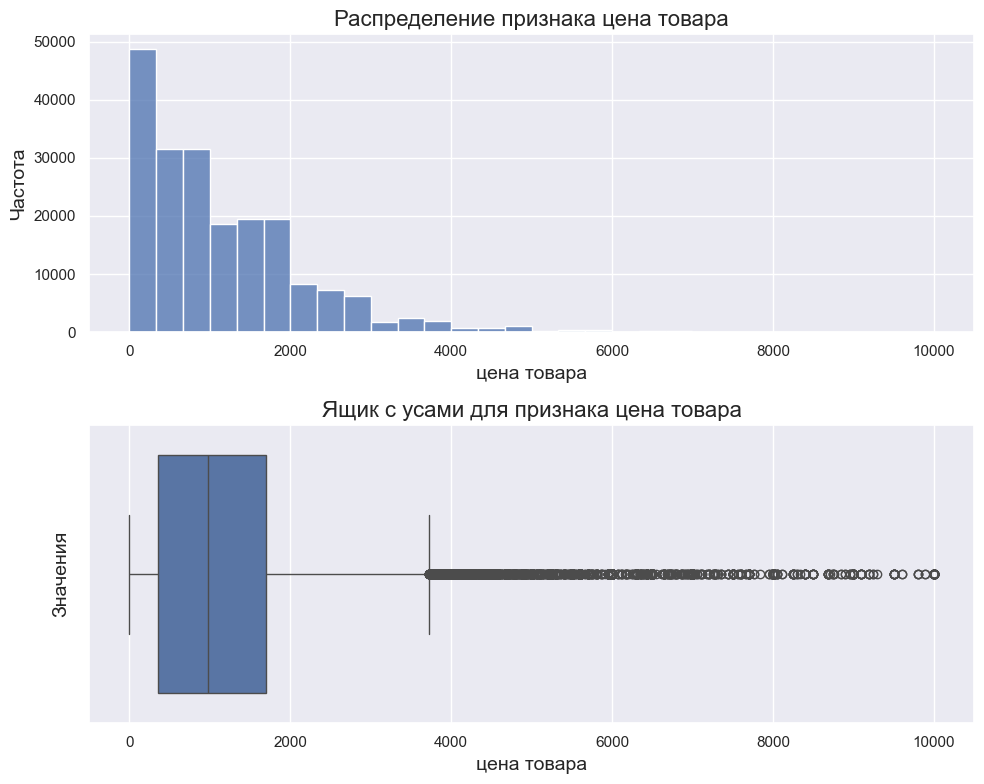

In [25]:
hist_box(purchases, 'price', 30, None, col_name)

Мы установили порог по цене одного товара в 10'000. Большенство строк имеют значение цены до 4'000.

### 4.4 Пропущенные значения и явные дубликаты

Создадим копии датасетов, которые будем обрабатывать

In [26]:
messages = initial_messages.copy()
target = initial_target.copy()
event = daily_event.copy()
chanel_event = daily_chanel_event.copy()

In [27]:
# Создадим словарь с датасетами для обработки
prep_df = {
    'messages': messages,
    'purchases': purchases,
    'target': target,
    'event': event,
    'chanel_event': chanel_event
}

Проверим пропущенные значения и полные дубликаты

In [28]:
for name, df in prep_df.items():
    print('')
    print(f"Датасет: {name}")
    miss_dupl(df)


Датасет: messages
Пропущенных значений:
bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

Явных дубликатов:
48610

Датасет: purchases
Пропущенных значений:
client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

Явных дубликатов:
72900

Датасет: target
Пропущенных значений:
client_id    0
target       0
dtype: int64

Явных дубликатов:
0

Датасет: event
Пропущенных значений:
date                   0
bulk_campaign_id       0
count_click            0
count_complain         0
count_hard_bounce      0
count_open             0
count_purchase         0
count_send             0
count_soft_bounce      0
count_subscribe        0
count_unsubscribe      0
nunique_click          0
nunique_complain       0
nunique_hard_bounce    0
nunique_open           0
nunique_purchase       0
nunique_send           0
nunique_soft_

Пропущенные значения отсутствуют, но в датасетах `messages` и `purchases` большое количество явных дубликатов. Это большая ошибка, т.к. по данным датасетам можно считать выручку, задвоение строк может внести кассовый разрыв, между зафиксированной выручкой и фактической. Удалим полные дубликаты

In [29]:
messages = messages.drop_duplicates()

In [30]:
purchases = purchases.drop_duplicates()

### 4.5 Потери при предобработке данных 

Посмотрим, сколько мы потеряли данных при предобработке данных

Датасет `messages`

In [31]:
round(
    100 - (messages.shape[0] / initial_messages.shape[0]
           ) * 100, 2)

0.38

Датасет `purchases`

In [32]:
round(
    100 - (purchases.shape[0] / initial_purchases.shape[0]
           ) * 100, 2)

36.22

Датасет `target`

In [33]:
round(
    100 - (target.shape[0] / initial_target.shape[0]
           ) * 100, 2)

0.0

Датасет `event`

In [34]:
round(
    100 - (event.shape[0] / daily_event.shape[0]
           ) * 100, 2)

0.0

Датасет `chanel_event`

In [35]:
round(
    100 - (chanel_event.shape[0] / daily_chanel_event.shape[0]
           ) * 100, 2)

0.0

В датасете `purchases`  36.22 % удаленных значений. Основное количество удаленных строк являются полные дубликаты. Возможно один клиент покупал один и тот же товар несколько раз в один день, но мы исключаем данный вариант, так как количество таких дубликатов очень велико.

### 4.6 Промежуточный вывод

Мы выполнили первичную обработку данных. 
В данных отсутствуют пропущенные значения. В датасете `purchases` удалены аномальные значения цены единицы товара (установлена верхняя граница 10000), а также удалены полные дубликаты - 72900 строк из 202208.

## 5. Разработка полезных признаков

**Датасет Purchases**

Найдем последнюю дату покупки

In [36]:
last_date = purchases['date'].max()

Разобьем датe покупки на день недели, месяц, час, год

In [37]:
purchases['purchase_weekday'] = purchases['date'].dt.weekday
purchases['purchase_hour'] = purchases['date'].dt.hour
purchases['purchase_month'] = purchases['date'].dt.month
purchases['purchase_year'] = purchases['date'].dt.month

Создадим новые признаки на основе даты

In [38]:
# Добавим новые признаки:
# 1. В какой день недели чаще всего были покупки
# 2. В какой час чаще всего были покупки
# 3. Склонность покупок в выходные дни

time_features = purchases.groupby('client_id').agg(
    favorite_weekday=(
        'purchase_weekday', 
        lambda x: x.mode()[0] if not x.mode().empty else -1),
    favorite_hour=(
        'purchase_hour', 
        lambda x: x.mode()[0] if not x.mode().empty else -1),
    weekend_purchases_ratio=(
        'purchase_weekday', 
        lambda x: ((x >= 5).sum() / len(x)) if len(x) > 0 else 0)
).reset_index()

Добавим общую стоимость покупки

In [39]:
purchases['total_price'] = \
purchases['quantity'] * purchases['price']

Создадим дополнительные признаки

In [40]:
# Объединим данные по client_id и с помощью agg добавим признаки
# 1. Количество дней с последней покупки
# 2. Количество дней с покупками
# 3. Общая сумма покупок
# 4. Средняя сумма покупок
# 5. Максимальная стоимость покупки
# 6. Общее количество товаров
# 7. Среднее количество товаров

purchases_new_features = purchases.groupby('client_id').agg(
    days_since_last_purchase=(
        'date', lambda x: (last_date - x.max()).days),
    purchase_frequency=('date', 'nunique'),
    total_spent=('total_price', 'sum'),
    avg_purchase_value=('total_price', 'mean'),
    max_purchase=('total_price', 'max'),
    total_items=('quantity', 'sum'),
    avg_items_per_order=('quantity', 'mean')
).reset_index()

Преобразуем столбец `category_ids` в более удобные и понятные признаки

In [41]:
# Преобразуем строки категорий в список
purchases['cat_list'] = purchases[
    'category_ids'
    ].str.strip("[]").str.replace("'", "").str.split(", ")

Сохраним последнюю и предпоследнюю нумерацию, т.к. они самые информативные для определенного товара. А также сохраним количество категорий

In [42]:
purchases['last_category'] = purchases[
    'cat_list'
    ].apply(lambda x: x[-1] if len(x) >= 1 else None)

purchases['second_last_category'] = purchases[
    'cat_list'
    ].apply(lambda x: x[-2] if len(x) >= 2 else None)

# Количество категорий в списке
purchases['category_count'] = purchases['cat_list'].apply(len)

Создадим новые признаки на основе категорий товаров

In [43]:
# Объединим данные по client_id и с помощью agg добавим признаки
# 1. Количество уникальных последних категорий
# 2. Количество уникальных предпоследних категорий
# 3. Самая частая последняя категория товара
# 4. Самая частая предпоследняя категория товара
# 5. Среднее количество категорий в покупке
# 6. Максимальное количество категорий в покупке
# 7. Минимальное количество категорий в покупке
# 8. Общее количество категорий во всех покупках


category_features = purchases.groupby('client_id').agg(
    unique_last_categories=('last_category', 'nunique'),
    unique_second_last_categories=('second_last_category', 'nunique'),
    most_frequent_last_category=('last_category', lambda x: x.mode()[0] if not x.mode().empty else None),
    most_frequent_second_last_category=('second_last_category', lambda x: x.mode()[0] if not x.mode().empty else None),
    avg_categories_per_purchase=('category_count', 'mean'),
    max_categories_in_purchase=('category_count', 'max'),
    min_categories_in_purchase=('category_count', 'min'),   
    total_categories=('category_count', 'sum')
).reset_index()

**Датасет messages**

Создадим новые признаки на основе сообщений

In [44]:
# Сгруппируем данные по `client_id` и создадим признаки
# 1. Общее количество сообщений
# 2. Количество открытых сообщений
# 3. Количество сообщений с кликами
# 4. Количество покупок из сообщений
# 5. Количесвто уникальных компаний
# 6. Количество дней с последнего сообщения
msg_features = messages.groupby('client_id').agg(
    total_messages=('event', 'size'),
    opened_count=('event', lambda x: (x == 'opened').sum()),
    clicked_count=('event', lambda x: (x == 'clicked').sum()),
    purchased_from_msg=('event', lambda x: (x == 'purchase').sum()),
    unique_campaigns=('bulk_campaign_id', 'nunique'),
    days_since_last_msg=('date', 
                         lambda x: (
                             last_date - x.max()
                             ).days if len(x) > 0 else 365)
).reset_index()

Создадим признаки на основе новых признаков

In [45]:
# 1. Доля сообщений, которые открыли
# 2. Доля кликов
# 3. Доля покупок
# 4. Конверсия открытых сообщений в клики

msg_features['open_rate'] = \
    msg_features['opened_count'] / msg_features[
        'total_messages'].replace(0, 1)

msg_features['click_rate'] = \
    msg_features['clicked_count'] / msg_features[
        'total_messages'].replace(0, 1)

msg_features['purchase_rate'] = \
    msg_features['purchased_from_msg'] / msg_features[
        'total_messages'].replace(0, 1)

msg_features['click_to_open'] = \
    msg_features['clicked_count'] / msg_features[
        'opened_count'].replace(0, 1)

Объединим все новые признаки и целевой признак в один датасет

In [46]:
# Создадим список с новыми признаками
features_list = [
    purchases_new_features, 
    category_features, 
    msg_features, 
    time_features
    ]

all_features = purchases_new_features

# Объединим все новые признаки в один датасет
for feature_df in features_list[1:]:
    all_features = pd.merge(all_features, feature_df, on='client_id', how='left')

Выведем все признаки

In [47]:
all_features.columns

Index(['client_id', 'days_since_last_purchase', 'purchase_frequency',
       'total_spent', 'avg_purchase_value', 'max_purchase', 'total_items',
       'avg_items_per_order', 'unique_last_categories',
       'unique_second_last_categories', 'most_frequent_last_category',
       'most_frequent_second_last_category', 'avg_categories_per_purchase',
       'max_categories_in_purchase', 'min_categories_in_purchase',
       'total_categories', 'total_messages', 'opened_count', 'clicked_count',
       'purchased_from_msg', 'unique_campaigns', 'days_since_last_msg',
       'open_rate', 'click_rate', 'purchase_rate', 'click_to_open',
       'favorite_weekday', 'favorite_hour', 'weekend_purchases_ratio'],
      dtype='str')

Объединим все новые признаки с целевой переменной

In [48]:
final_data = pd.merge(all_features, target, on='client_id', how='inner')

Выведем размер нового датасета

In [49]:
final_data.shape

(49752, 30)

Посмотрим общую информацию для нашего датасета

In [50]:
final_data.info()

<class 'pandas.DataFrame'>
RangeIndex: 49752 entries, 0 to 49751
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   client_id                           49752 non-null  int64  
 1   days_since_last_purchase            49752 non-null  int64  
 2   purchase_frequency                  49752 non-null  int64  
 3   total_spent                         49752 non-null  float64
 4   avg_purchase_value                  49752 non-null  float64
 5   max_purchase                        49752 non-null  float64
 6   total_items                         49752 non-null  int64  
 7   avg_items_per_order                 49752 non-null  float64
 8   unique_last_categories              49752 non-null  int64  
 9   unique_second_last_categories       49752 non-null  int64  
 10  most_frequent_last_category         49752 non-null  str    
 11  most_frequent_second_last_category  49751 non-null  

Получился датасет с 30 колонками и 49752 строками. Видно, что в некоторых столбцах присутствуют пропуски. Посмотрим их количество

In [51]:
final_data.isna().sum()

client_id                                0
days_since_last_purchase                 0
purchase_frequency                       0
total_spent                              0
avg_purchase_value                       0
max_purchase                             0
total_items                              0
avg_items_per_order                      0
unique_last_categories                   0
unique_second_last_categories            0
most_frequent_last_category              0
most_frequent_second_last_category       1
avg_categories_per_purchase              0
max_categories_in_purchase               0
min_categories_in_purchase               0
total_categories                         0
total_messages                        7852
opened_count                          7852
clicked_count                         7852
purchased_from_msg                    7852
unique_campaigns                      7852
days_since_last_msg                   7852
open_rate                             7852
click_rate 

Видно, что одинаковое количество пропусков в признаках связаных с рассылками. 

In [52]:
# Заполним все пропуски связанные с рассылками 0
# принимая, что сообщения не направлялись 
final_data.loc[final_data['total_messages'].isna(), [
    'total_messages', 
    'opened_count',
    'clicked_count', 
    'purchased_from_msg',
    'unique_campaigns',
    'open_rate',
    'click_rate',
    'purchase_rate',
    'click_to_open'
     ]] = 0

# Количество дней с последней рассылке зададим 365 дней
final_data.loc[final_data[
    'days_since_last_msg'].isna(), 
    'days_since_last_msg'] = 365

In [53]:
final_data.isna().sum()

client_id                             0
days_since_last_purchase              0
purchase_frequency                    0
total_spent                           0
avg_purchase_value                    0
max_purchase                          0
total_items                           0
avg_items_per_order                   0
unique_last_categories                0
unique_second_last_categories         0
most_frequent_last_category           0
most_frequent_second_last_category    1
avg_categories_per_purchase           0
max_categories_in_purchase            0
min_categories_in_purchase            0
total_categories                      0
total_messages                        0
opened_count                          0
clicked_count                         0
purchased_from_msg                    0
unique_campaigns                      0
days_since_last_msg                   0
open_rate                             0
click_rate                            0
purchase_rate                         0


Удалим пропус в столбце `most_frequent_second_last_category`

In [54]:
final_data.dropna(
    subset=['most_frequent_second_last_category'],
    inplace=True
    )

Мы обработали пропуски

Обработаем выбросы

In [55]:
def winsorize_series(series, limits=(0.01, 0.01)):
    """Ограничивает выбросы сверху и снизу."""
    lower = series.quantile(limits[0])
    upper = series.quantile(1 - limits[1])
    return series.clip(lower, upper)

cols_to_winsorize = ['total_spent', 'max_purchase', 'avg_interval', 'max_interval']
for col in cols_to_winsorize:
    if col in final_data.columns:
        final_data[col] = winsorize_series(final_data[col])

Выбросы обработаны

### 5.1 Промежуточный вывод

Мы создали новые признаки:
1. days_since_last_purchase - дней с последней покупки

2. purchase_frequency - частота покупок

3. total_spent - всего потрачено

4. avg_purchase_value - средний чек

5. max_purchase - максимальная покупка

6. total_items - всего товаров

7. avg_items_per_order - среднее количество товаров в заказе

8. unique_last_categories - уникальные последние категории

9. unique_second_last_categories - уникальные предпоследние категории

10. most_frequent_last_category - самая частая последняя категория

11. most_frequent_second_last_category - самая частая предпоследняя категория

12. avg_categories_per_purchase - среднее количество категорий на покупку

13. max_categories_in_purchase - максимальное количество категорий в покупке

14. min_categories_in_purchase - минимальное количество категорий в покупке

15. total_categories - всего категорий

16. total_messages - всего сообщений

17. opened_count - количество открытий

18. clicked_count - количество кликов

19. purchased_from_msg - покупок из сообщений

20. unique_campaigns - уникальные кампании

21. days_since_last_msg - дней с последнего сообщения

22. open_rate - процент открытий

23. click_rate - процент кликов

24. purchase_rate - процент покупок

25. click_to_open - конверсия из открытия в клик

26. favorite_weekday - любимый день недели

27. favorite_hour - любимый час

28. weekend_purchases_ratio - доля покупок в выходные


## 6. Подготовка данных для обучения моделей

### 6.1 Корреляционный анализ

Простроим матрицу корреляций

d:\Users\my_project\Marketing\marketing_venv\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable open_rate for analysis 1. Dropping this column
  warnings.warn(
d:\Users\my_project\Marketing\marketing_venv\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable click_rate for analysis 1. Dropping this column
  warnings.warn(
d:\Users\my_project\Marketing\marketing_venv\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable click_to_open for analysis 1. Dropping this column
  warnings.warn(
d:\Users\my_project\Marketing\marketing_venv\Lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable clicked_count for analysis 1. Dropping this column
  warnings.warn(
d:\Users\my_project\Marketing\marketing_venv\Lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable favorite_hour for analysis 1. Dropping this c

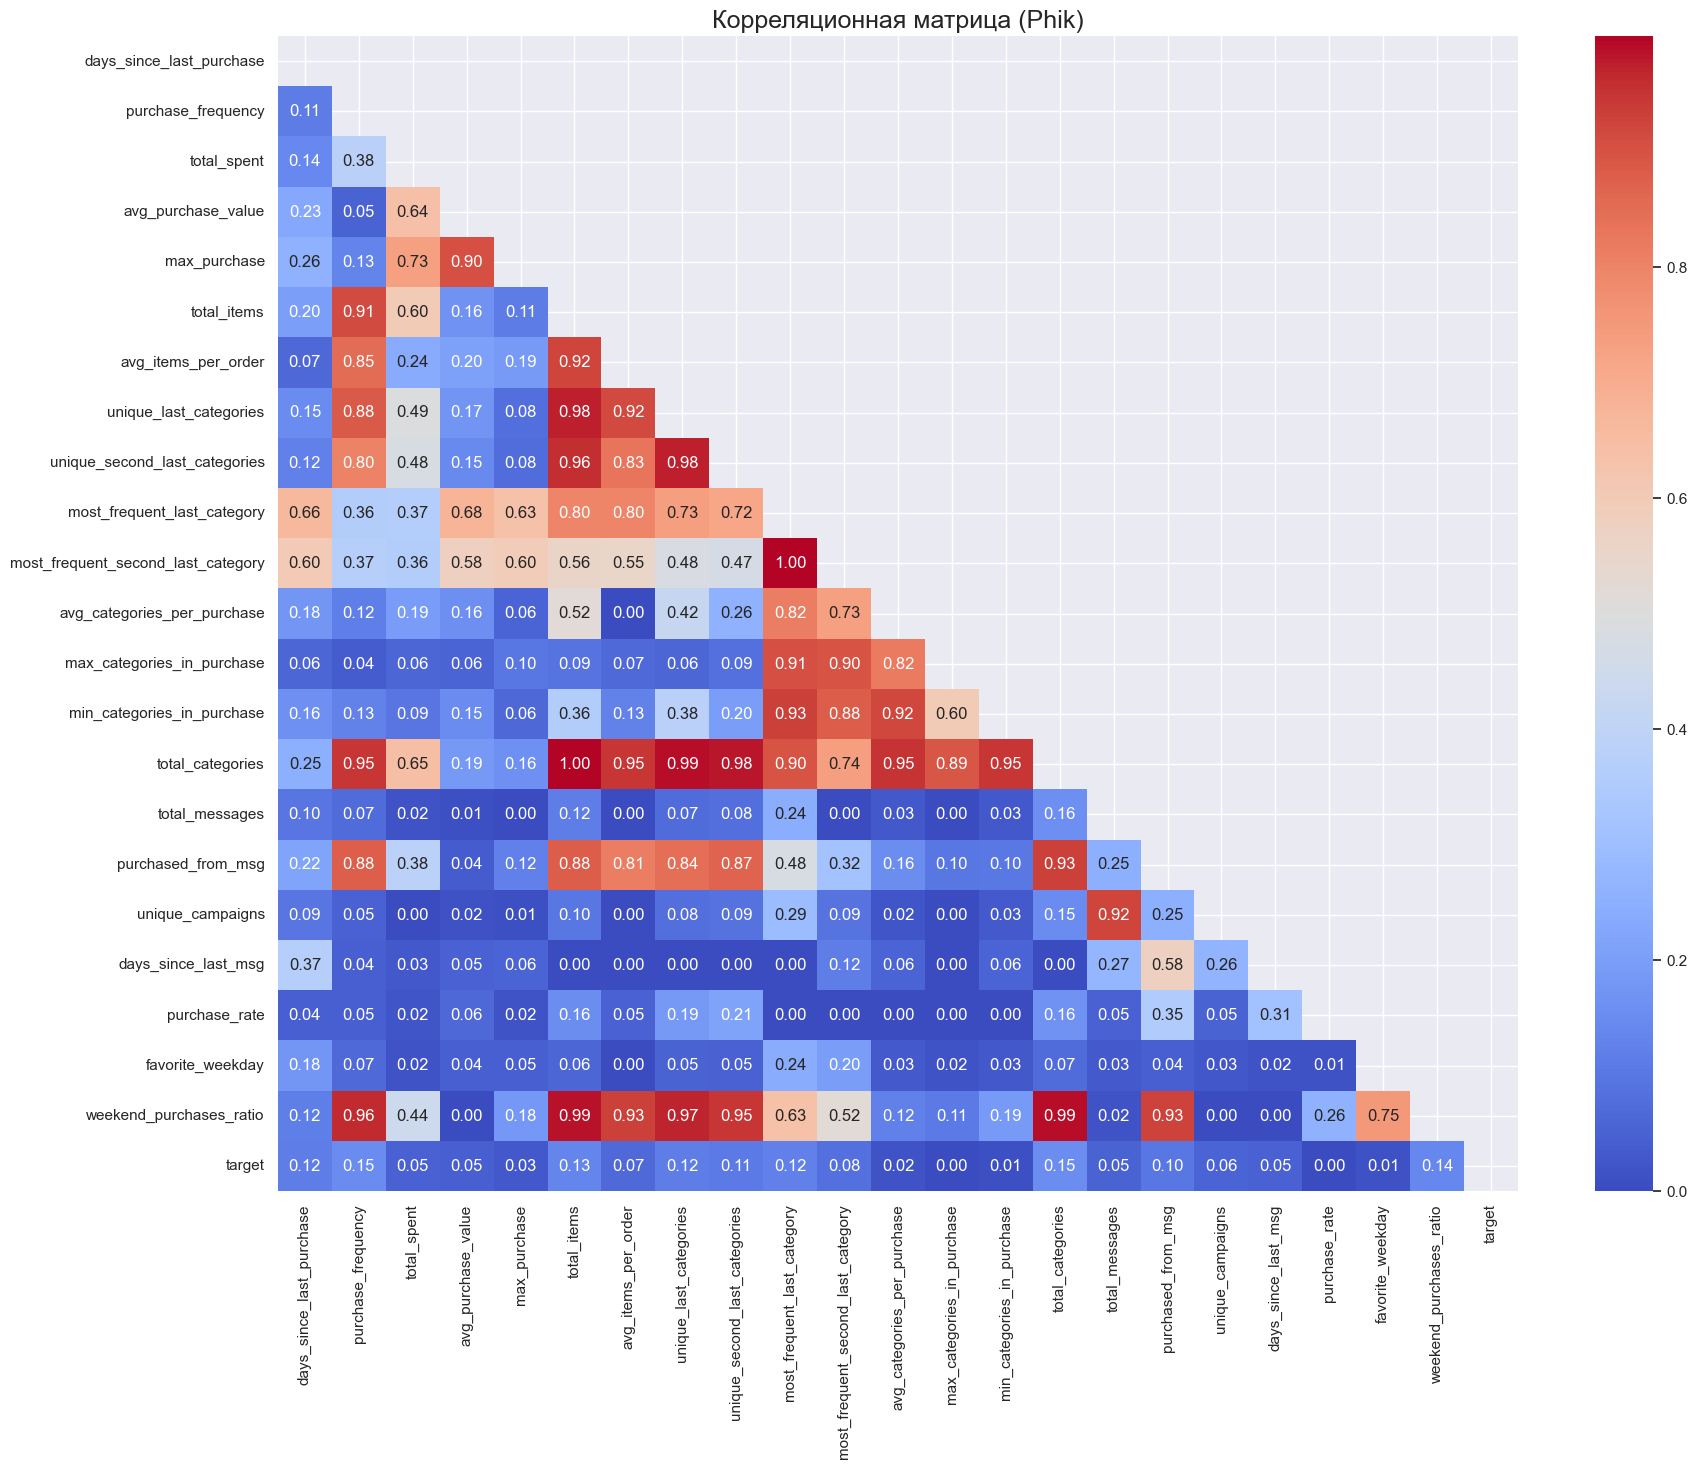

In [56]:

matrix_data = final_data.copy()
matrix_data.drop('client_id', axis=1, inplace=True)
interval_cols = [
    'days_since_last_purchase',
    'total_spent',
    'avg_purchase_value', 
    'max_purchase', 
    'avg_categories_per_purchase', 
    'total_messages', 
    'unique_campaigns', 
    'days_since_last_msg', 
    'open_rate', 
    'click_rate', 
    'purchase_rate', 
    'click_to_open'
    ]
phik_mat(matrix_data, interval_cols=interval_cols)

По матрице корреляций видно, сильно коррелирующие столбцы: `weekend_purchases_ratio`, `total_categories`, `unique_last_categories`, `unique_second_last_categories`, `most_frequent_categories`, `avg_categories_per_purchase`. А также признаки, которые не имеют корреляцию с целевым признаком: `max_categories_in_purchase`, `purchase_rate`. Удалим данные столбцы для устранения мультиколлинеарности и упрощения расчетов при работе модели

In [57]:
final_data = final_data.drop([
    'weekend_purchases_ratio',
    'total_categories',
    'unique_last_categories',
    'unique_second_last_categories',
    'most_frequent_last_category',
    'most_frequent_second_last_category',
    'avg_categories_per_purchase',
    'max_categories_in_purchase',
    'purchase_rate',
    'favorite_hour'
], axis=1)

Повторим корреляционный анализ

d:\Users\my_project\Marketing\marketing_venv\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable open_rate for analysis 1. Dropping this column
  warnings.warn(
d:\Users\my_project\Marketing\marketing_venv\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable click_rate for analysis 1. Dropping this column
  warnings.warn(
d:\Users\my_project\Marketing\marketing_venv\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable click_to_open for analysis 1. Dropping this column
  warnings.warn(
d:\Users\my_project\Marketing\marketing_venv\Lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable clicked_count for analysis 1. Dropping this column
  warnings.warn(
d:\Users\my_project\Marketing\marketing_venv\Lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable opened_count for analysis 1. Dropping this co

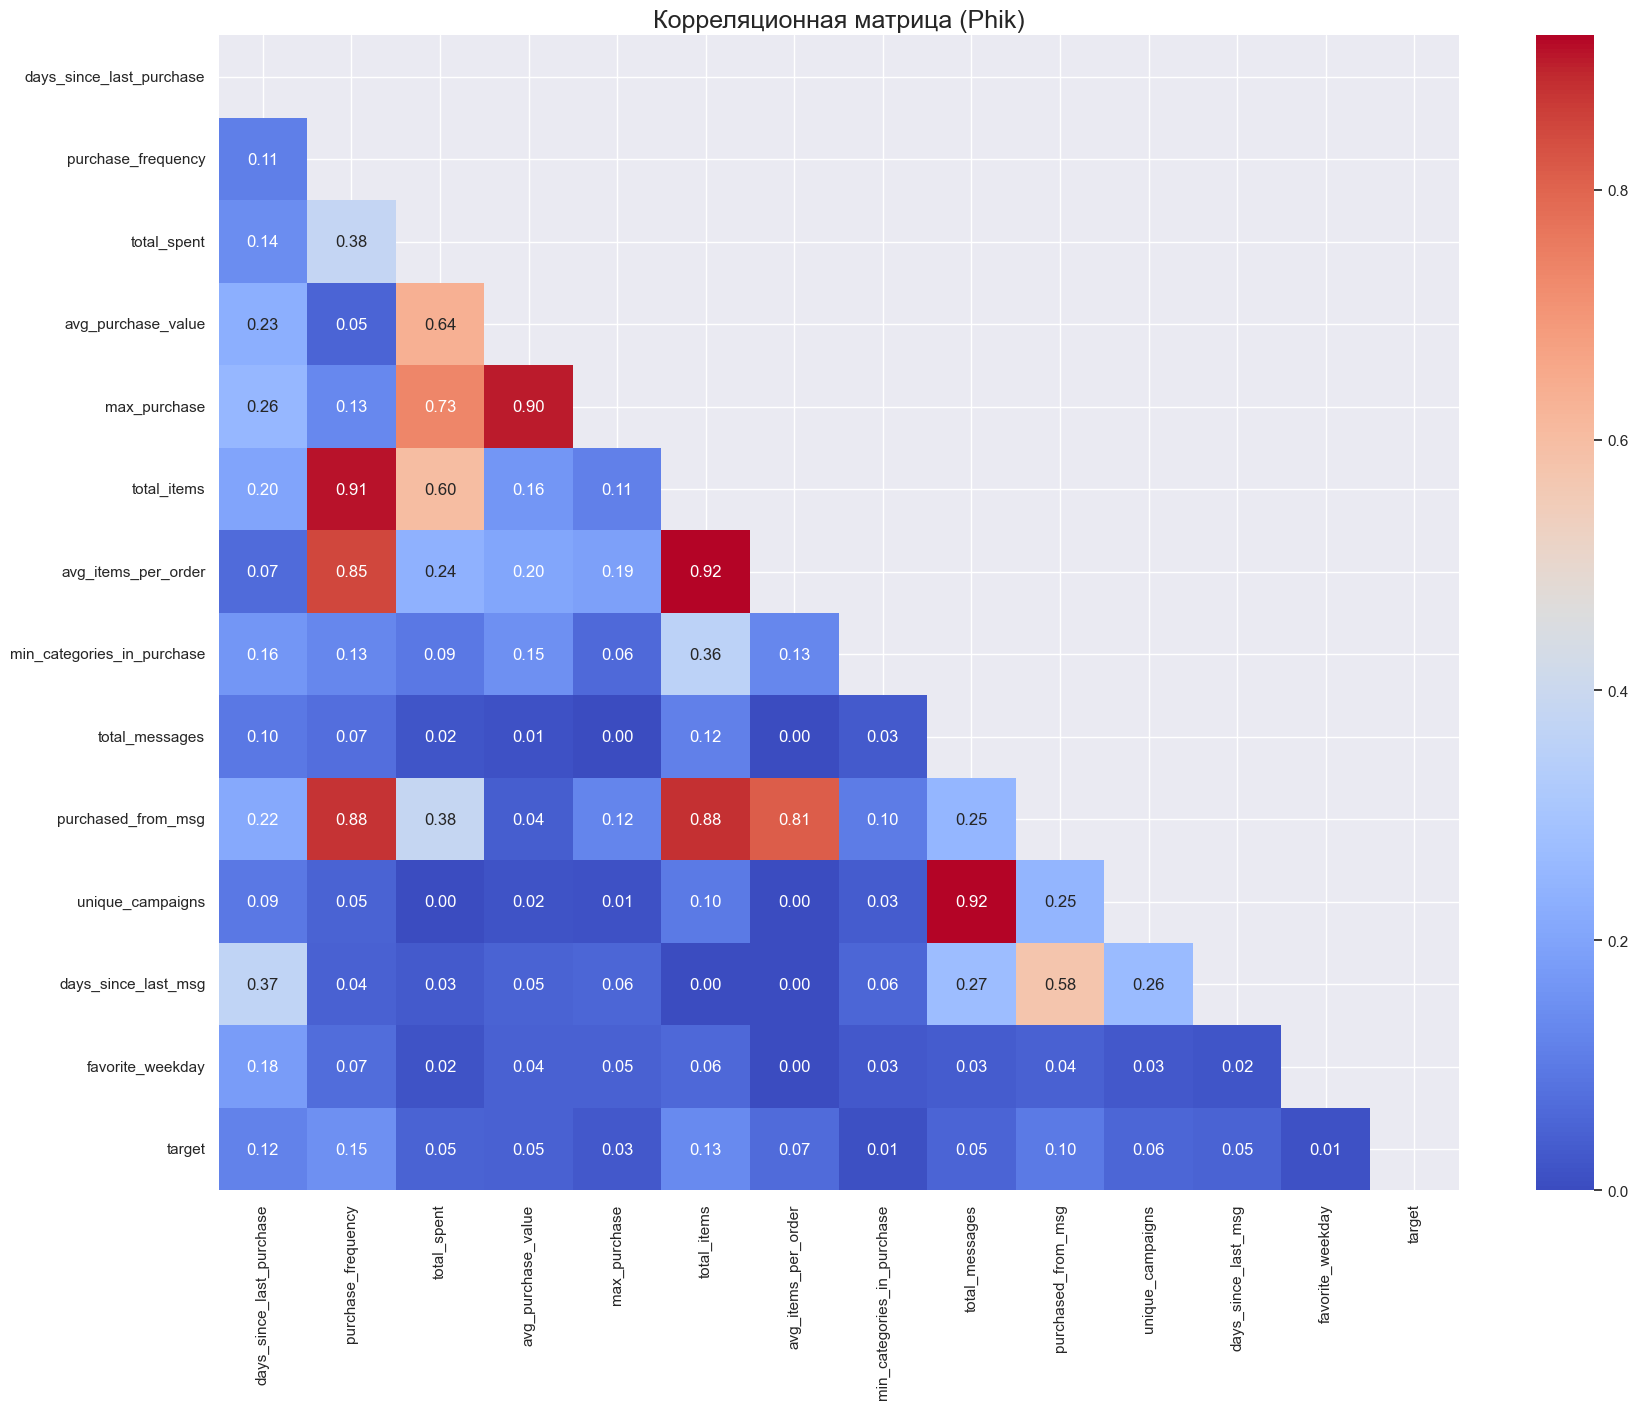

In [58]:
matrix_data = final_data.copy()
matrix_data.drop('client_id', axis=1, inplace=True)
interval_cols = [
    'days_since_last_purchase',
    'total_spent',
    'avg_purchase_value', 
    'max_purchase',  
    'total_messages', 
    'unique_campaigns', 
    'days_since_last_msg', 
    'open_rate', 
    'click_rate', 
    'click_to_open'
    ]
phik_mat(matrix_data, interval_cols=interval_cols)

Мы удалили все мультиколлинеарные признаки с показателем более 0.95, а также признаки не влияющие на целевую переменную.

Выведем информацию о полученном датасете

In [59]:
final_data.info()

<class 'pandas.DataFrame'>
Index: 49751 entries, 0 to 49751
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   client_id                   49751 non-null  int64  
 1   days_since_last_purchase    49751 non-null  int64  
 2   purchase_frequency          49751 non-null  int64  
 3   total_spent                 49751 non-null  float64
 4   avg_purchase_value          49751 non-null  float64
 5   max_purchase                49751 non-null  float64
 6   total_items                 49751 non-null  int64  
 7   avg_items_per_order         49751 non-null  float64
 8   min_categories_in_purchase  49751 non-null  int64  
 9   total_messages              49751 non-null  float64
 10  opened_count                49751 non-null  float64
 11  clicked_count               49751 non-null  float64
 12  purchased_from_msg          49751 non-null  float64
 13  unique_campaigns            49751 non-null  flo

### 6.2 Подготовка выборок для обучения

Поменяем индексы на `client_id`

In [60]:
final_data.set_index('client_id', inplace=True)

Выделим целевой и входные признаки

In [61]:
X = final_data.drop(['target'], axis=1)
y = final_data['target']

Разделим данные на тренировочную и тестовую выборки

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size= TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=y
)

In [63]:
print(
    f'Тренировочная выборка:{X_train.shape},{y_train.shape} \
    \nТестовая выборка:{X_test.shape}, {y_test.shape}'
)

Тренировочная выборка:(37313, 18),(37313,)     
Тестовая выборка:(12438, 18), (12438,)


### 6.3 Пайплайн для предобработки данных

Подготовим списки со столбцами для обработки

In [64]:
ohe_columns = [
    'favorite_weekday'
    ]
num_columns = [
    'days_since_last_purchase', 
    'purchase_frequency',
    'total_spent',
    'avg_purchase_value', 
    'max_purchase',
    'total_items',
    'avg_items_per_order',
    'min_categories_in_purchase',
    'total_messages',
    'opened_count',
    'clicked_count',
    'purchased_from_msg',
    'unique_campaigns',
    'days_since_last_msg',
    'open_rate',
    'click_rate',
    'click_to_open'
    ]

Создадим пайплайн для предобработки данных

In [65]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(
            missing_values=np.nan, 
            strategy='most_frequent'
        )),
        ('ohe', OneHotEncoder(
            drop='first', 
            handle_unknown='ignore', 
            sparse_output=False))
    ]
)

Создадим единный пайплайн для предобработки

In [66]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', RobustScaler(), num_columns)
    ], 
    remainder='passthrough'
)

Создадим единный пайплайн для предобработки данных и обучения модели

In [67]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

### 6.4 Промежуточный вывод

При корреляционном анализе была обнаружена мультиколлинеарность между входными признаками, а также незначимые признаки, которые в дальнейшем были удалены. Данные разделены на тренировочную и тестовую выборки, подготовлен пайплайн для предобработки и обучения моделей.

## 7. Обучение моделей

Обучим модели:
1) DecisionTreeClassifier
2) KNeighborsClassifier
3) RandomForestClassifier
4) LGBMRegressor
5) XGBClassifier

Обучение будем проводить по каждой модели отдельно, для большего контроля.

In [68]:
scoring={
    'roc_auc': 'roc_auc',
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1'
}

**DesisionTreeClassifier**

Cоздадим словарь гиперпараметров 

In [103]:
param_grid_1 = {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 20),
        'models__min_samples_split': range(2, 20),
        'models__class_weight': ['balanced', None]
    }

Обучим модель

In [104]:
start_time = time.time()

randomized_search_1 = RandomizedSearchCV(
    pipe_final, 
    param_grid_1, 
    cv=5,
    scoring=scoring,
    refit='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1, 
    error_score='raise'
)

randomized_search_1.fit(X_train, y_train)

end_time = time.time()
f"Время подбора гиперпараметров: {(end_time - start_time)/60:.2f} минут"

'Время подбора гиперпараметров: 0.08 минут'

Найдем метрики на кросс-валидации, сортировка по ROC-AUC

In [105]:
cv_results_1 = pd.DataFrame(randomized_search_1.cv_results_)
print_best_metrics(cv_results_1)

МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ (по ROC-AUC)
ROC_AUC      | Среднее: 0.6807
F1           | Среднее: 0.0674
PRECISION    | Среднее: 0.0360
RECALL       | Среднее: 0.5480


**KNeighborsClassifier**

In [106]:
param_grid_2 = {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 30),
        'models__weights': ['uniform', 'distance'],
        'models__metric': ['euclidean', 'manhattan', 'minkowski'],
        'models__leaf_size': range(10, 30) 
    }

In [107]:
start_time = time.time()

randomized_search_2 = RandomizedSearchCV(
    pipe_final, 
    param_grid_2, 
    cv=5,
    scoring=scoring,
    refit='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1, 
    error_score='raise'
)

randomized_search_2.fit(X_train, y_train)

end_time = time.time()
f"Время подбора гиперпараметров: {(end_time - start_time)/60:.2f} минут"

'Время подбора гиперпараметров: 0.36 минут'

In [108]:
cv_results_2 = pd.DataFrame(randomized_search_2.cv_results_)
print_best_metrics(cv_results_2)

МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ (по ROC-AUC)
ROC_AUC      | Среднее: 0.6136
F1           | Среднее: 0.0000
PRECISION    | Среднее: 0.0000
RECALL       | Среднее: 0.0000


**RandomForestClassifier**

In [109]:
param_grid_3 = {    
    'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
    'models__n_estimators': [100, 200, 300],
    'models__max_depth': [5, 10, 20, None],
    'models__min_samples_split': [2, 5, 10, 20],
    'models__min_samples_leaf': [1, 2, 4, 10],
    'models__class_weight': ['balanced', None],
    'preprocessor__num': ['passthrough'] 
}

In [110]:
start_time = time.time()

randomized_search_3 = RandomizedSearchCV(
    pipe_final, 
    param_grid_3, 
    cv=5,
    scoring=scoring,
    refit='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1, 
    error_score='raise'
)

randomized_search_3.fit(X_train, y_train)

end_time = time.time()
f"Время подбора гиперпараметров: {(end_time - start_time)/60:.2f} минут"

'Время подбора гиперпараметров: 0.78 минут'

In [112]:
cv_results_3 = pd.DataFrame(randomized_search_3.cv_results_)
print_best_metrics(cv_results_3)

МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ (по ROC-AUC)
ROC_AUC      | Среднее: 0.7215
F1           | Среднее: 0.0837
PRECISION    | Среднее: 0.0456
RECALL       | Среднее: 0.5105


**LGBMRegressor**

In [117]:
param_grid_4 = {
    'models': [LGBMClassifier(random_state=RANDOM_STATE)],
    'models__n_estimators': [125, 250, 370],
    'models__max_depth': range(-1, 16),
    'models__learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
    'models__num_leaves': range(15, 120),
    'models__min_child_samples': range(1, 15),
    'models__min_split_gain': [0.0, 0.1],
    'models__class_weight': ['balanced', None],
    'models__verbose': [-1],
    'preprocessor__num': ['passthrough']
}

In [118]:
start_time = time.time()

randomized_search_4 = RandomizedSearchCV(
    pipe_final, 
    param_grid_4, 
    cv=5,
    scoring=scoring,
    refit='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1, 
    error_score='raise'
)

randomized_search_4.fit(X_train, y_train)

end_time = time.time()
f"Время подбора гиперпараметров: {(end_time - start_time)/60:.2f} минут"

'Время подбора гиперпараметров: 0.72 минут'

In [119]:
cv_results_4 = pd.DataFrame(randomized_search_4.cv_results_)
print_best_metrics(cv_results_4)

МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ (по ROC-AUC)
ROC_AUC      | Среднее: 0.7033
F1           | Среднее: 0.0785
PRECISION    | Среднее: 0.0423
RECALL       | Среднее: 0.5493


**XGBClassifier**

In [120]:
param_grid_5 = {    
        'models': [XGBClassifier(random_state=RANDOM_STATE)],
        'models__iterations': [300, 500, 800, 1200],
        'models__depth': range(3, 10),
        'models__learning_rate': [0.03, 0.05, 0.1],
        'models__l2_leaf_reg': range(1, 10),
        'models__scale_pos_weight': [20, 40, 51, 70, 100, 150],
        'models__border_count': range(64, 254),
        'models__random_strength': [0, 1, 2],
        'models__bagging_temperature': [0, 0.5, 1],
        'preprocessor__num': ['passthrough']
    }

In [123]:
start_time = time.time()

randomized_search_5 = RandomizedSearchCV(
    pipe_final, 
    param_grid_5, 
    cv=5,
    scoring=scoring,
    refit='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1, 
    error_score='raise'
)

randomized_search_5.fit(X_train, y_train)

end_time = time.time()
f"Время подбора гиперпараметров: {(end_time - start_time)/60:.2f} минут"

d:\Users\my_project\Marketing\marketing_venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:55:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "bagging_temperature", "border_count", "depth", "iterations", "l2_leaf_reg", "random_strength" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


'Время подбора гиперпараметров: 0.08 минут'

In [124]:
cv_results_5 = pd.DataFrame(randomized_search_5.cv_results_)
print_best_metrics(cv_results_5)

МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ (по ROC-AUC)
ROC_AUC      | Среднее: 0.6953
F1           | Среднее: 0.0969
PRECISION    | Среднее: 0.0569
RECALL       | Среднее: 0.3259


### 7.1 Промежуточный вывод

Было обучено 5 моделей классификации: 
1) DecisionTreeClassifier
2) KNeighborsClassifier
3) RandomForestClassifier
4) LGBMRegressor
5) XGBClassifier

Лучший результат на кросс-валидации по метрике ROC-AUC показала модель RandomForestClassifier, вторая по метрике модель LGBMRegressor.

## 8. Улучшение модели и максимизация метрики ROC-AUC

Мы нашли две лучшие модели, улучшим модель перебором большего количества вариантов гиперпараметров для улучшения метрики ROC-AUC

Улучшим модель RandomForestClassifier

In [ ]:
param_grid_best_1 = {
    'model': [RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)],  
    'model__n_estimators': [100, 200, 300, 400],  
    'model__max_depth': [3, 5, 7, 10, 15, 20, None],  
    'model__min_samples_split': [2, 5, 10, 20, 30], 
    'model__min_samples_leaf': [1, 2, 4, 8, 12, 20],  
    'model__max_features': ['sqrt', 'log2', 0.5, 0.7, None], 
    'model__max_samples': [0.6, 0.7, 0.8, 0.9, None],    
    'model__class_weight': [
        'balanced',
        'balanced_subsample',
        {0: 1, 1: 10},  
        {0: 1, 1: 20},
        None
    ],    
    'model__criterion': ['gini', 'entropy'],
    'model__bootstrap': [True, False],  
    'preprocessor__num': ['passthrough']
}

In [126]:
start_time = time.time()

randomized_search_best_1 = RandomizedSearchCV(
    pipe_final, 
    param_grid_best_1, 
    cv=5,
    scoring=scoring,
    refit='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1, 
    error_score='raise',
    n_iter=50
)

randomized_search_best_1.fit(X_train, y_train)

end_time = time.time()
f"Время подбора гиперпараметров: {(end_time - start_time)/60:.2f} минут"

d:\Users\my_project\Marketing\marketing_venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


'Время подбора гиперпараметров: 2.59 минут'

In [127]:
cv_results_best_1 = pd.DataFrame(randomized_search_best_1.cv_results_)
print_best_metrics(cv_results_best_1)

МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ (по ROC-AUC)
ROC_AUC      | Среднее: 0.7215
F1           | Среднее: 0.0837
PRECISION    | Среднее: 0.0456
RECALL       | Среднее: 0.5105


При большем переборе гиперпараметров модель не улучшила метрику ROC-AUC

Проверим модель LGBMСlassifier

In [ ]:
param_grid_best_2 = {
    'models': [LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)],
    'models__n_estimators': [100, 200, 300, 500],
    'models__max_depth': [3, 5, 7, 10, -1],
    'models__learning_rate': [0.01, 0.05, 0.1, 0.15],
    'models__num_leaves': [15, 31, 63, 127],
    'models__min_child_samples': [10, 20, 30, 50],
    'models__min_split_gain': [0.0, 0.001, 0.01],
    'models__scale_pos_weight': [40, 49, 55, 60, 75],
    'models__reg_alpha': [0.0, 0.01, 0.1],
    'models__reg_lambda': [0.0, 0.1, 1.0],
    'models__subsample': [0.7, 0.8, 0.9],
    'models__colsample_bytree': [0.7, 0.8, 0.9],
    'preprocessor__num': ['passthrough']
}

In [138]:
start_time = time.time()

randomized_search_best_2 = RandomizedSearchCV(
    pipe_final, 
    param_grid_best_2, 
    cv=5,
    scoring=scoring,
    refit='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1, 
    error_score='raise',
    n_iter=50
)

randomized_search_best_2.fit(X_train, y_train)

end_time = time.time()
f"Время подбора гиперпараметров: {(end_time - start_time)/60:.2f} минут"

'Время подбора гиперпараметров: 1.96 минут'

In [139]:
cv_results_best_2 = pd.DataFrame(randomized_search_best_2.cv_results_)
print_best_metrics(cv_results_best_2)

МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ (по ROC-AUC)
ROC_AUC      | Среднее: 0.7280
F1           | Среднее: 0.0732
PRECISION    | Среднее: 0.0388
RECALL       | Среднее: 0.6561


### 8.1 Промежуточный вывод

Мы выделили 2 лучшие модели и улучшили модель LGBMСlassifier, подняв метрику ROC-AUC с 0,7033 до 0,7280. Улучшение модели RandomForestClassifier не дало результата, метрика не изменилась и равняется 0.7215

## 9. Тестирование лучшей модели

Сохраним лучшую модель 

In [140]:
best_model = randomized_search_best_2.best_estimator_

Выполним предсказание на тестовых данных

In [144]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1] 

d:\Users\my_project\Marketing\marketing_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Users\my_project\Marketing\marketing_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Найдем метрику ROC-AUC на тестовых данных и визуализируем кривую

ROC-AUC score: 0.7467


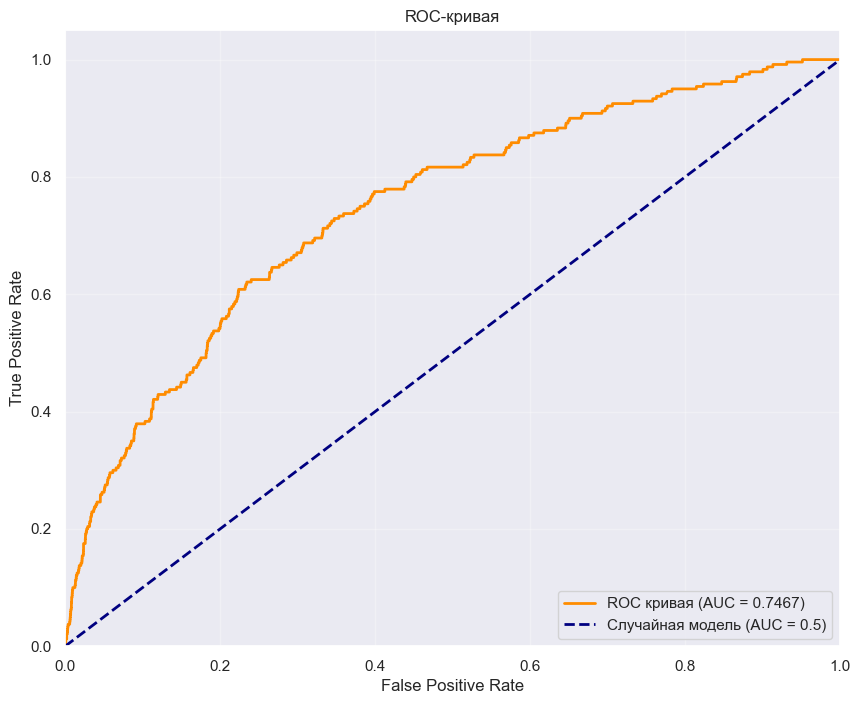


Площадь под ROC-кривой (AUC): 0.7467


In [ ]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC кривая (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Случайная модель (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nПлощадь под ROC-кривой (AUC): {auc(fpr, tpr):.4f}")

ROC-AUC на тестовых данных равен 0.7467, что является хорошим показателям (требование ROC-AUC более 0.7)

Выведем параметры лучшей модели

In [169]:
print(best_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['favorite_weekday']),
                                                 ('num', 'passthrough',
                                                  ['days_since_last_purchase',
                                                

Построим матрицу ошибок

Матрица ошибок:
[[8185 4013]
 [  73  167]]


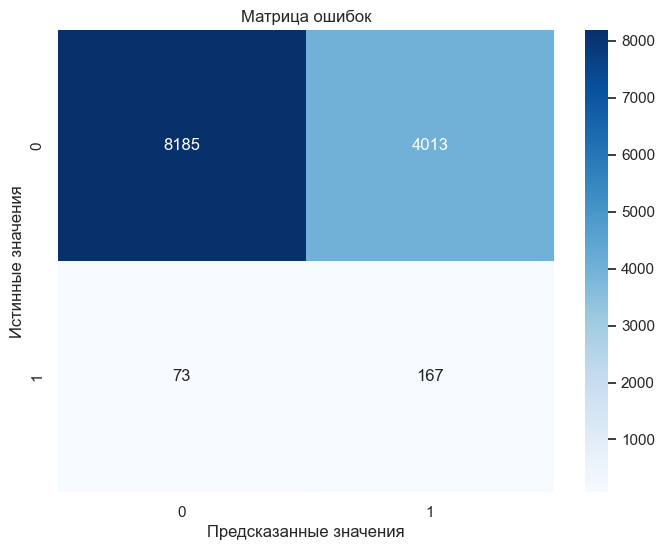

In [152]:
cm = confusion_matrix(y_test, y_pred)
print("Матрица ошибок:")
print(cm)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.show()

По матрице ошибок видно, что у нас малое количество ложноотрицетельных примеров, но большое количество ложноположительных примеров. Это можно объяснить дисбалансом между классами. Бизнес ожидает больший отклик от клиентов, но на самом деле большая часть из них не совершит покупку.

Построим важность признаков

Топ-30 важных признаков:
                            feature  importance
6     num__days_since_last_purchase         769
14              num__total_messages         419
9           num__avg_purchase_value         397
18            num__unique_campaigns         325
7           num__purchase_frequency         320
11                 num__total_items         215
19         num__days_since_last_msg         197
10                num__max_purchase         162
8                  num__total_spent         159
17          num__purchased_from_msg         123
13  num__min_categories_in_purchase         109
5           ohe__favorite_weekday_6          44
1           ohe__favorite_weekday_2          37
4           ohe__favorite_weekday_5          17
12         num__avg_items_per_order          16
3           ohe__favorite_weekday_4           6
2           ohe__favorite_weekday_3           2
0           ohe__favorite_weekday_1           0
16               num__clicked_count           0
15             

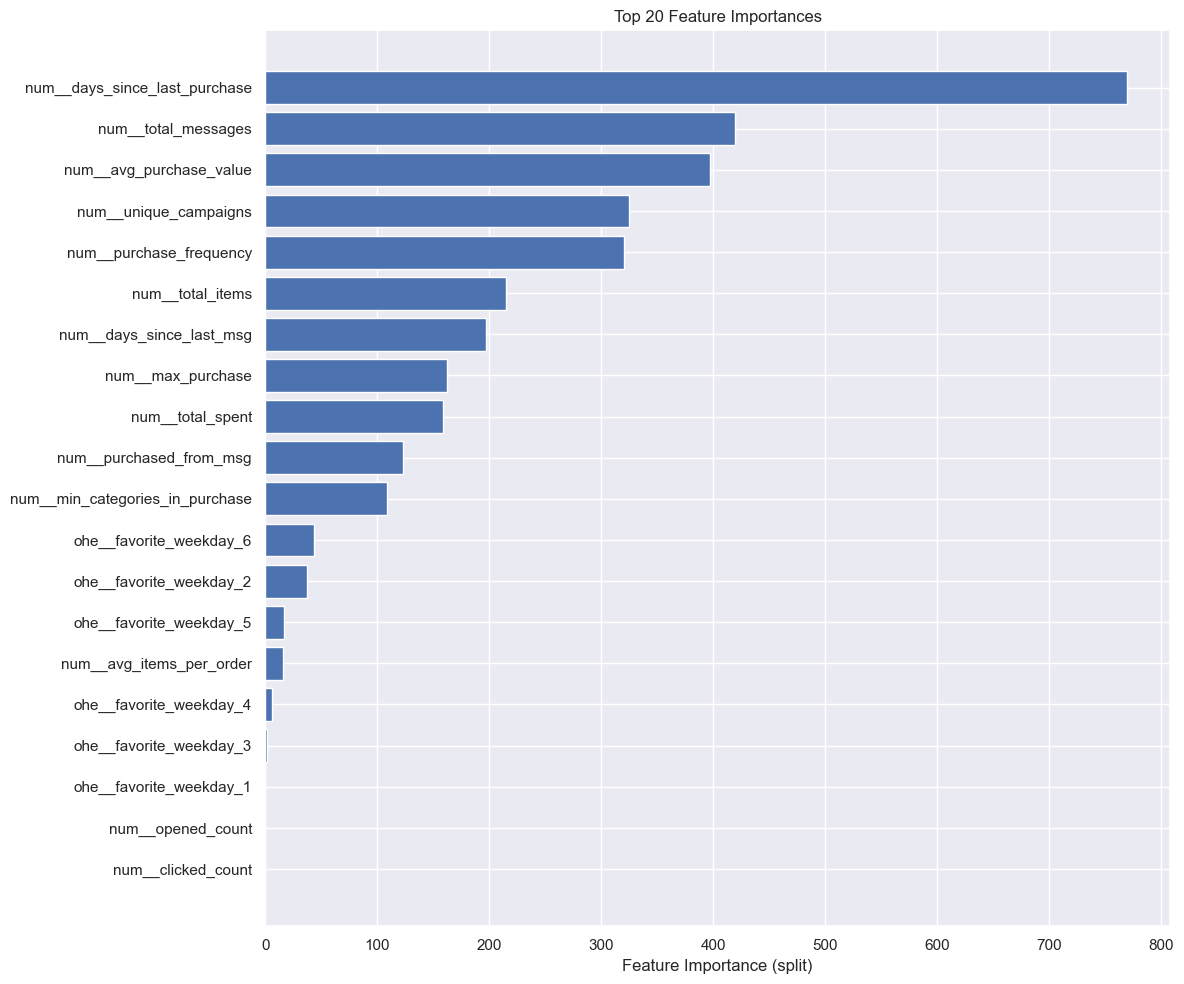

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Минимальный рабочий вариант без permutation importance
lgbm_model = best_model.named_steps['models']
preprocessor = best_model.named_steps['preprocessor']

# Получаем имена признаков после препроцессинга
feature_names = preprocessor.get_feature_names_out()

# Получаем важность признаков (только split)
feature_importances = lgbm_model.feature_importances_

# Создаем DataFrame
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

# Выводим результаты
print("Топ-30 важных признаков:")
print(feature_importance_df.head(30))

# Простая визуализация
plt.figure(figsize=(12, 10))
top_features = feature_importance_df.head(20).sort_values('importance', ascending=True)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance (split)')
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.savefig('simple_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

По важности признаков мы определили 10 самых важных

1. days_since_last_purchase - дней с последней покупки

2. total_messages - всего сообщений

3. avg_purchase_value - средний чек

4. unique_campaigns - уникальные кампании

5. purchase_frequency - частота покупок

6. total_items - всего товаров

7. days_since_last_msg - дней с последнего сообщения

8. max_purchase - максимальная покупка

9. total_spent - всего потрачено

10. purchased_from_msg - покупок из сообщений


## 10. Вывод

- Данные заружены, установлена настройка при чтении файла, для обработки столбцов с датами. Наименования столбцов имеют "змеиный" регистр. Все данные имеют корректный тип данных.

- В данных отсутствуют пропущенные значения. В датасете `purchases` удалены аномальные значения цены единицы товара (установлена верхняя граница 10000), а также удалены полные дубликаты - 72900 строк из 202208.

- Мы создали новые признаки:

        1. days_since_last_purchase - дней с последней покупки

        2. purchase_frequency - частота покупок

        3. total_spent - всего потрачено

        4. avg_purchase_value - средний чек

        5. max_purchase - максимальная покупка

        6. total_items - всего товаров

        7. avg_items_per_order - среднее количество товаров в заказе

        8. unique_last_categories - уникальные последние категории

        9. unique_second_last_categories - уникальные предпоследние категории

        10. most_frequent_last_category - самая частая последняя категория

        11. most_frequent_second_last_category - самая частая предпоследняя категория

        12. avg_categories_per_purchase - среднее количество категорий на покупку

        13. max_categories_in_purchase - максимальное количество категорий в покупке

        14. min_categories_in_purchase - минимальное количество категорий в покупке

        15. total_categories - всего категорий

        16. total_messages - всего сообщений

        17. opened_count - количество открытий

        18. clicked_count - количество кликов

        19. purchased_from_msg - покупок из сообщений

        20. unique_campaigns - уникальные кампании

        21. days_since_last_msg - дней с последнего сообщения

        22. open_rate - процент открытий

        23. click_rate - процент кликов

        24. purchase_rate - процент покупок

        25. click_to_open - конверсия из открытия в клик

        26. favorite_weekday - любимый день недели

        27. favorite_hour - любимый час

        28. weekend_purchases_ratio - доля покупок в выходные

- При корреляционном анализе была обнаружена мультиколлинеарность между входными признаками, а также незначимые признаки, которые в дальнейшем были удалены. Данные разделены на тренировочную и тестовую выборки, подготовлен пайплайн для предобработки и обучения моделей.

- Было обучено 5 моделей классификации: 
    1) DecisionTreeClassifier
    2) KNeighborsClassifier
    3) RandomForestClassifier
    4) LGBMRegressor
    5) XGBClassifier

    Лучший результат на кросс-валидации по метрике ROC-AUC показала модель RandomForestClassifier, вторая по метрике модель LGBMRegressor.

- Мы выделили 2 лучшие модели и улучшили модель LGBMСlassifier, подняв метрику ROC-AUC с 0,7033 до 0,7280. Улучшение модели RandomForestClassifier не дало результата, метрика не изменилась и равняется 0.7215

- ROC-AUC на тестовых данных равен 0.7467, что является хорошим показателям (требование ROC-AUC более 0.7). У нас малое количество ложноотрицетельных примеров, но большое количество ложноположительных примеров. Это можно объяснить дисбалансом между классами. Бизнес ожидает больший отклик от клиентов, но на самом деле большая часть из них не совершит покупку.

- По важности признаков мы определили 10 самых важных

        1. days_since_last_purchase - дней с последней покупки

        2. total_messages - всего сообщений

        3. avg_purchase_value - средний чек

        4. unique_campaigns - уникальные кампании

        5. purchase_frequency - частота покупок

        6. total_items - всего товаров

        7. days_since_last_msg - дней с последнего сообщения

        8. max_purchase - максимальная покупка

        9. total_spent - всего потрачено

        10. purchased_from_msg - покупок из сообщений
